In [1]:
from modules import evaluate_Y_M_scaling_reln_cosmo_cat as ymsr
from modules.settings import global_mmf_settings as gset
from modules.settings import global_mmf_settings as gset
from cosmology import cosmo_fn
from simulate import cluster_templates as cltemp
import multiprocessing as mp
from scipy.optimize import curve_fit
from data_preprocess import get_tangent_planes as gtp
from filters import modular_multi_matched_filter as mmf
from flat_sky_codes import tangent_plane_analysis as tpa
from flat_sky_codes import flat_sky_analysis as fsa

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
outpath="../results/planck_pr1/planck_cosmo_cat/"
gset.setup_mmf_config(dataset="planck_pr1",outpath=outpath,chmin=100.,xsize=10.,result_midfix="",do_band_pass=True)
figpath=gset.mmfset.paths["result_figs"]
pmmf=ymsr.Y_M_scaling()
xsz_cat=pmmf.xsz_cat
tmplt=cltemp.cluster_spectro_spatial_templates(T_min=0.,T_max=40.,T_step=0.1,theta500_min=2.,theta500_max=55.,theta_step=1.)

# Get data cluster model

In [60]:
idx=56
print xsz_cat["theta500"][idx]
filename=xsz_cat["FILENAME"][idx]
data=gtp.return_data(filename)
ps_mask=gtp.return_ps_mask(filename)
op=mmf.multi_matched_filter(pmmf.tmplt.sp_ft_bank,pmmf.tmplt.sz_spec_bank,pmmf.tmplt.chfiltr,pmmf.tmplt.fn_yerr_norm)
op.get_data_ft(data*ps_mask*pmmf.emask,smwin=2)
err,snr_max0,yc,otheta500T0,ans0=op.return_optimal_theta500(Tc=0.,mask_fdata=False)
print otheta500T0

15.5971714998
24.0700700701


In [117]:
idx=0
print xsz_cat["theta500"][idx]
filename=xsz_cat["FILENAME"][idx]
data=gtp.return_data(filename)
ps_mask=gtp.return_ps_mask(filename)
ell,cl=fsa.map2cl(data[3,]*ps_mask,gset.mmfset.reso)


idx=57
print xsz_cat["theta500"][idx]
filename=xsz_cat["FILENAME"][idx]
data=gtp.return_data(filename)
ps_mask=gtp.return_ps_mask(filename)
ell2,cl2=fsa.map2cl(data[3,]*ps_mask,gset.mmfset.reso)



5.00885432703
21.4657266322


<IPython.core.display.Javascript object>


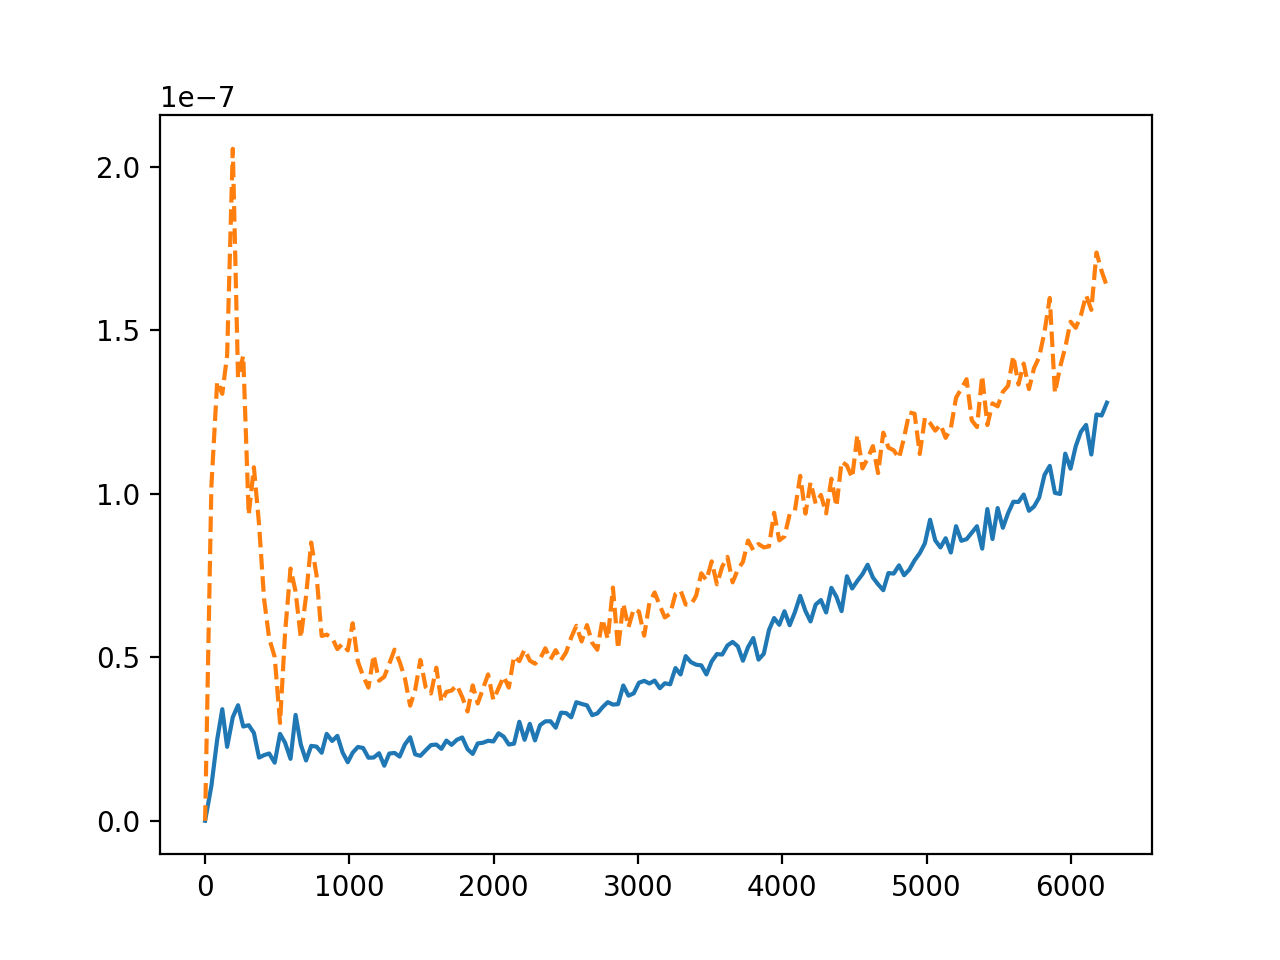

In [119]:
figure()
plot(ell,ell*(ell+1)*cl)
plot(ell2,ell*(ell+1)*cl2,"--")

<IPython.core.display.Javascript object>


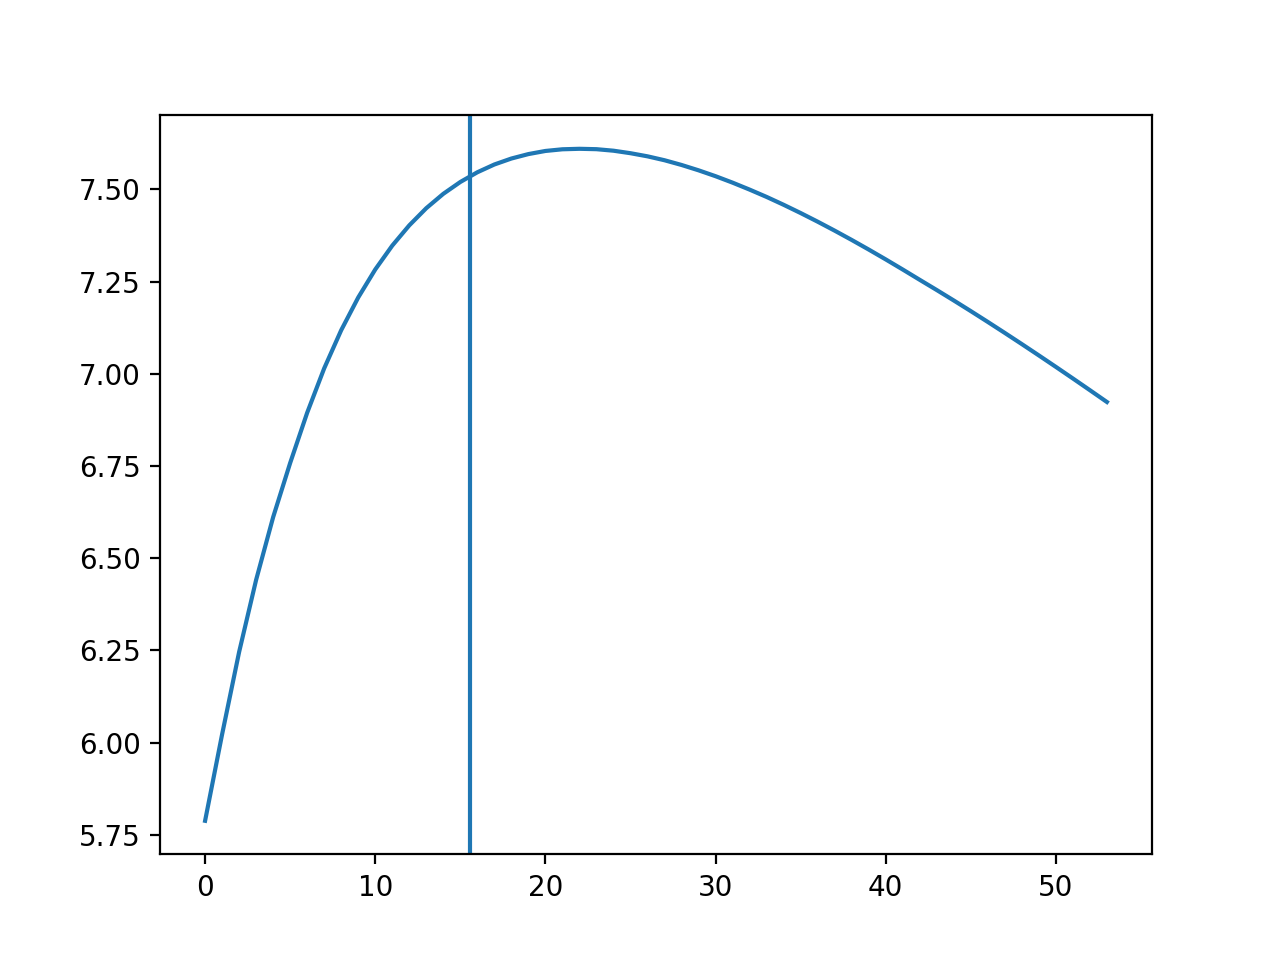

In [64]:
figure()
plot(ans0[1,:])
axvline(xsz_cat["theta500"][idx])

In [65]:
fdata,err,fdatar,data_mfcm=pmmf.return_cluster_catalogue(idx)
print max((fdata*pmmf.cmask).ravel()),err

5.64990093423e-05 6.91459486987e-06


<IPython.core.display.Javascript object>


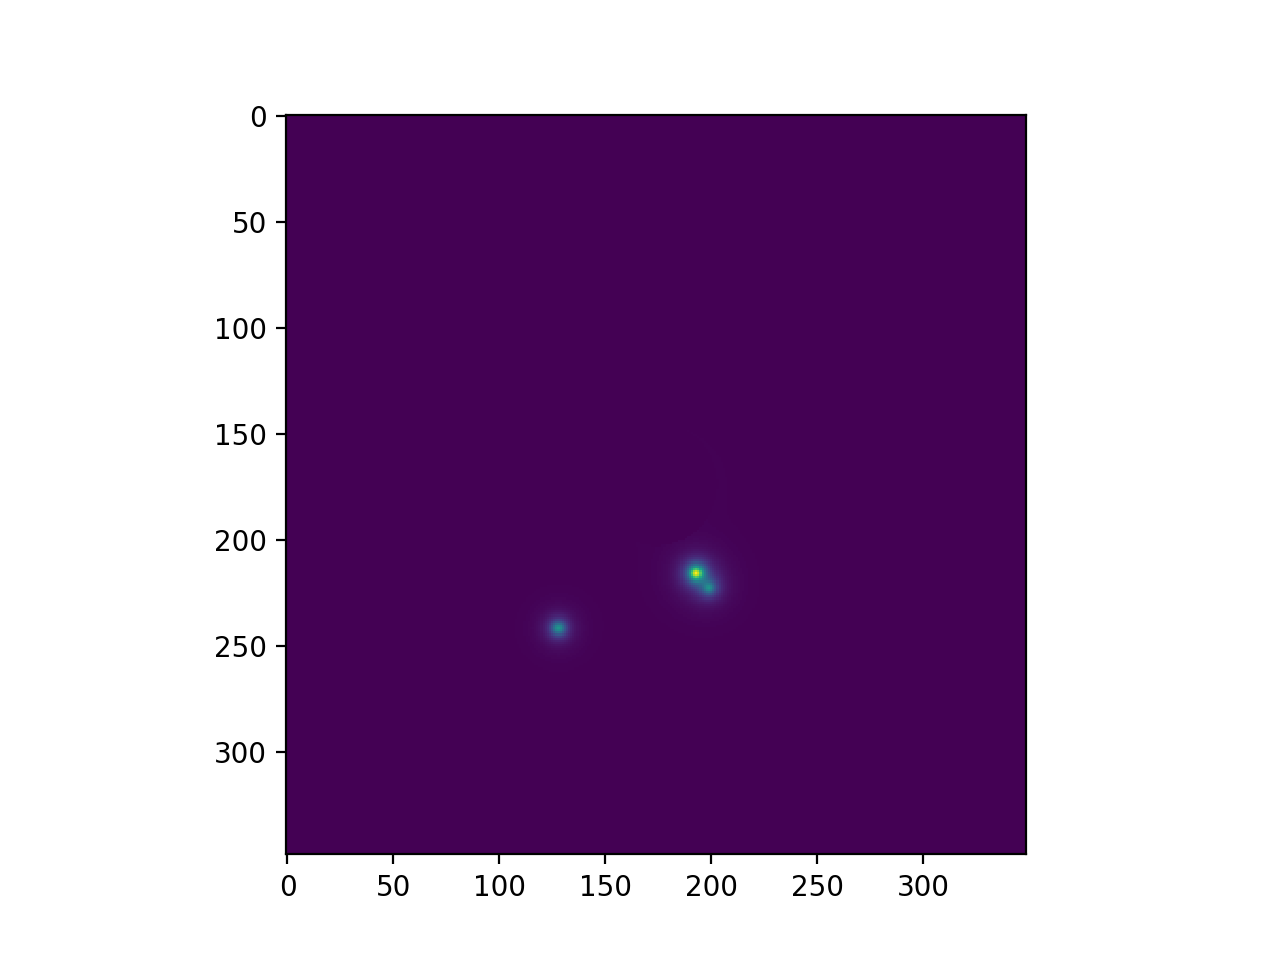

In [67]:
figure()
imshow(data_mfcm[3,]*(1-pmmf.cmask))

# Subtract data cluster model from data - This data is now only foregrounds + CMB + noise

In [68]:
data=gtp.return_data(xsz_cat["FILENAME"][idx])
ps_mask=gtp.return_ps_mask(xsz_cat["FILENAME"][idx])
data=data-data_mfcm[0,]*(1-pmmf.cmask)

In [69]:
glon=pmmf.xsz_cat["GLON"][idx]
glat=pmmf.xsz_cat["GLAT"][idx]
# redshift=pmmf.xsz_cat["z"][idx]
# theta500=pmmf.xsz_cat["theta500"][idx]
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
ix,iy=projop.ang2ij(glon,glat)
list_theta500=np.arange(2.,56.,1.)
otheta500=np.zeros_like(list_theta500)
for ic,theta500 in enumerate(list_theta500):
    cluster=cltemp.sc.gen_field_cluster_template(ix,iy,theta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
    cluster_model_ft=fsa.map2alm(cluster,gset.mmfset.reso)
    sim_mfcm=np.zeros(data.shape,dtype=np.float64)
    #op=mmf.multi_matched_filter(pmmf.tmplt.sp_ft_bank,pmmf.tmplt.sz_spec_bank,pmmf.tmplt.chfiltr,pmmf.tmplt.fn_yerr_norm)
    for i, ch in enumerate(gset.mmfset.channels):
        sim_mfcm[i,]=fsa.alm2map(cluster_model_ft*op.chfiltr[ch]*op.sz_spec_bank[0][ch],gset.mmfset.reso)
        
    temp_data=(data+ sim_mfcm)*ps_mask*pmmf.emask
    data_ft=np.zeros((np.size(gset.mmfset.channels),gset.mmfset.npix,gset.mmfset.npix),complex)
    for i,ch in enumerate(gset.mmfset.channels):
        data_ft[i,]=fsa.map2alm(temp_data[i,],gset.mmfset.reso)
    
    op.data_ft=np.copy(data_ft)
    err,snr_max0,yc,otheta500[ic],ans0=op.return_optimal_theta500(Tc=0.,mask_fdata=False)
    print theta500,otheta500[ic]

2.0 22.1071071071
3.0 21.2052052052
4.0 20.0910910911
5.0 19.1361361361
6.0 18.2872872873
7.0 17.5445445445
8.0 17.014014014
9.0 16.6956956957
10.0 16.5895895896
11.0 16.8548548549
12.0 16.9079079079
13.0 17.0670670671
14.0 17.3323323323
15.0 17.7037037037
16.0 18.2342342342
17.0 18.8178178178
18.0 19.4544544545
19.0 20.1971971972
20.0 20.992992993
21.0 21.7887887888
22.0 22.6376376376
23.0 23.4864864865
24.0 24.3883883884
25.0 25.2902902903
26.0 26.1921921922
27.0 27.0940940941
28.0 28.049049049
29.0 29.004004004


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


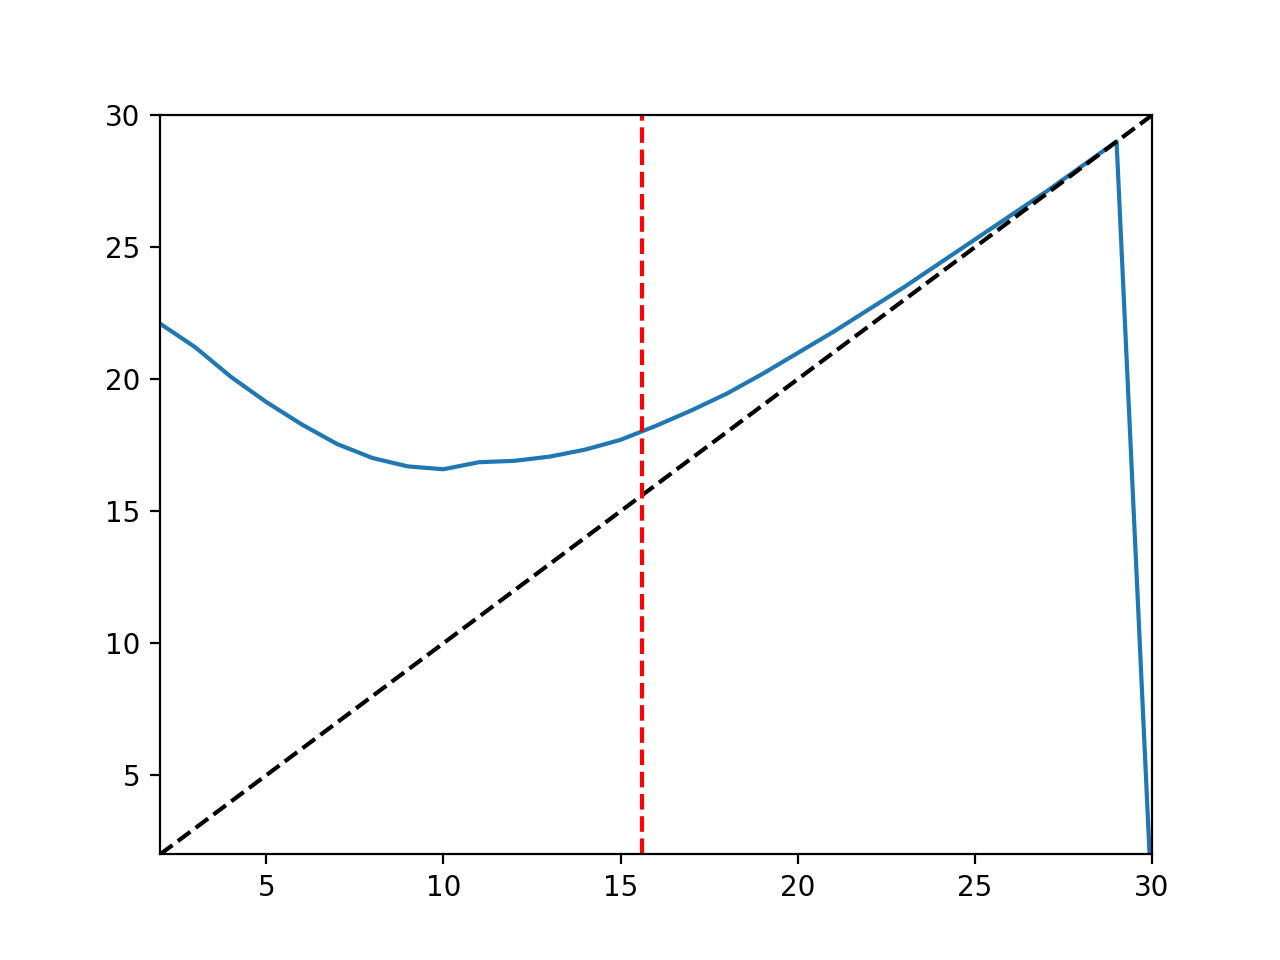

(2, 30)

In [71]:
figure()
plot(list_theta500,otheta500)
plot(list_theta500,list_theta500,"k--")
axvline(xsz_cat["theta500"][idx],c="r",ls="--")
xlim(2,30)
ylim(2,30)

In [72]:
xsz_cat["theta500"][idx]

15.597171499753243

In [101]:
lmax_cutoff=3000
ell=np.arange(20000) ; bl=np.ones(np.size(ell),float) ; bl[ell>=lmax_cutoff]=0.
lpfiltr=fsa.get_fourier_filter(bl,nxpix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,ell=ell)

In [102]:
cluster=cltemp.sc.gen_field_cluster_template(ix,iy,5.,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
cluster_model_ft=fsa.map2alm(cluster,gset.mmfset.reso)
smcluster=fsa.alm2map(cluster_model_ft*lpfiltr,gset.mmfset.reso)

cluster2=cltemp.sc.gen_field_cluster_template(ix,iy,10.,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
cluster_model_ft=fsa.map2alm(cluster2,gset.mmfset.reso)
smcluster2=fsa.alm2map(cluster_model_ft*lpfiltr,gset.mmfset.reso)

<IPython.core.display.Javascript object>


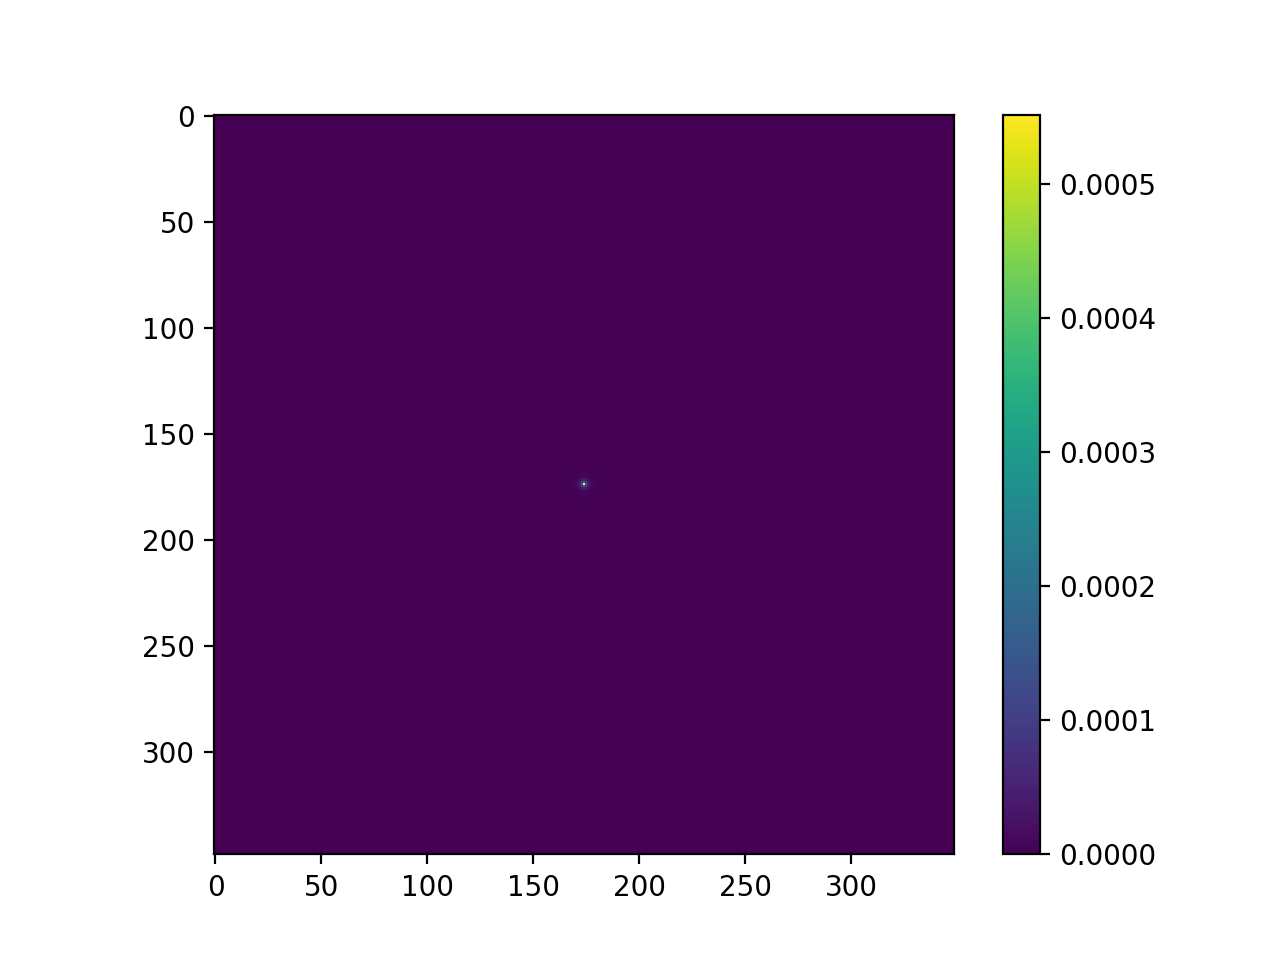

<IPython.core.display.Javascript object>


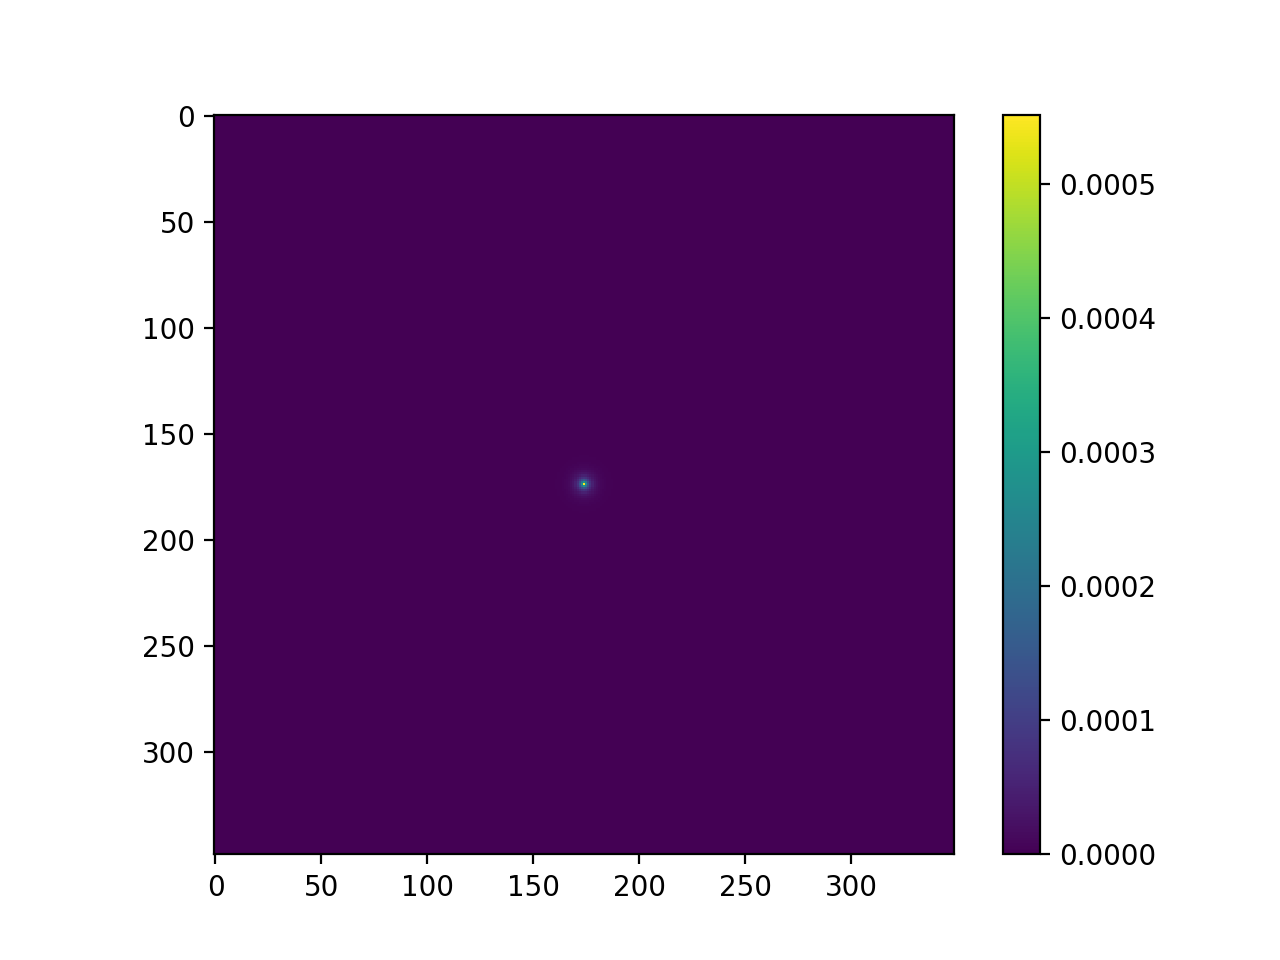

<IPython.core.display.Javascript object>


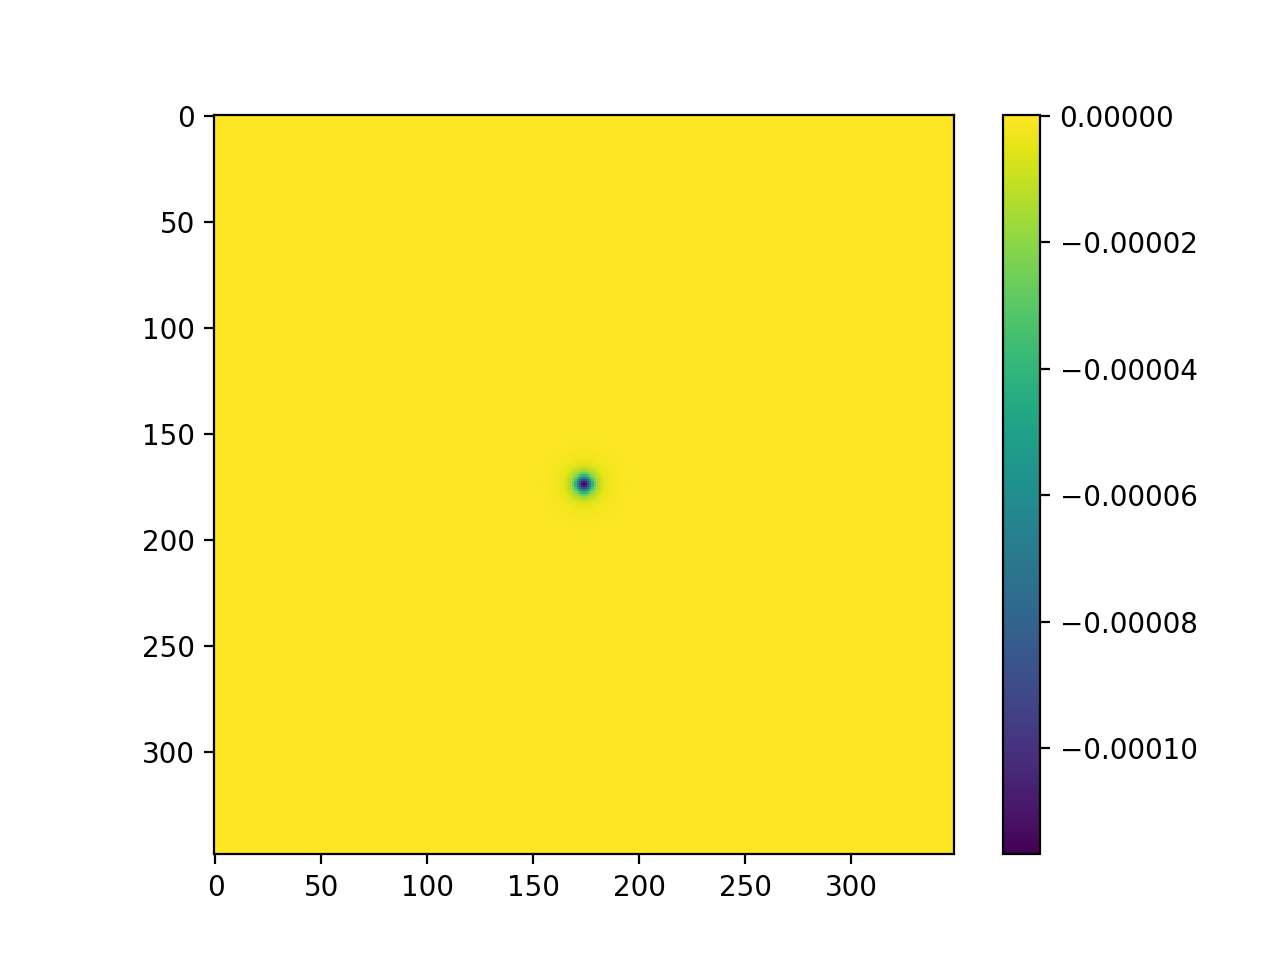

<IPython.core.display.Javascript object>


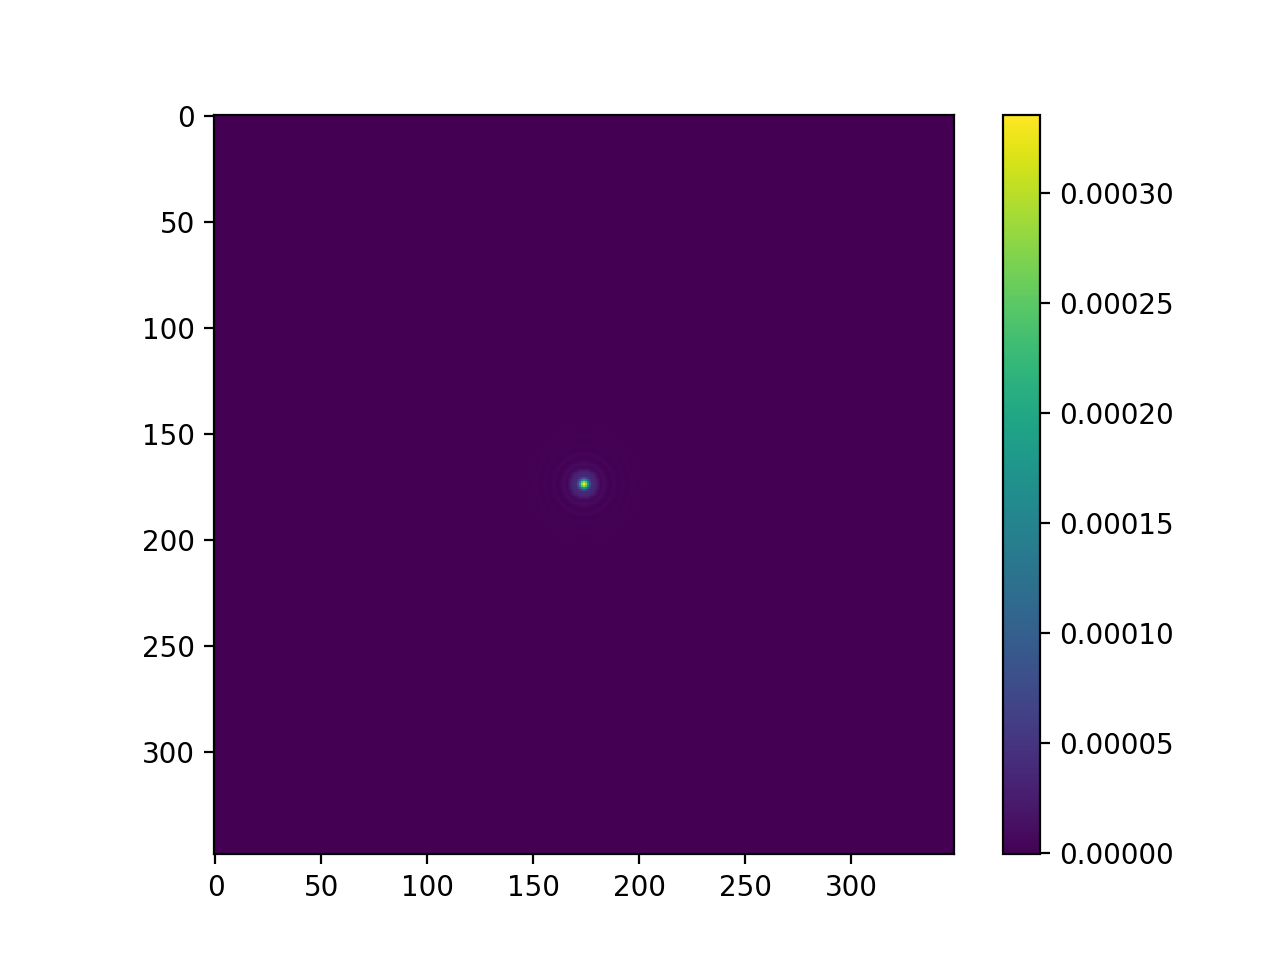

In [105]:
figure()
imshow(cluster)
colorbar()

figure()
imshow(cluster2)
colorbar()

figure()
imshow(smcluster-smcluster2)
colorbar()

figure()
imshow(smcluster2)
colorbar()